# Cleaning and Exploring the Datasets

**Star Trek Series**

| Series | Seasons | Episodes | Originally released | In Dataset |
| :----: | :----: | :----: | :----: | :----: |
| The Original Series | 3 | 79 | September 8, 1966 – June 3, 1969 | yes |
| The Animated Series | 2 | 22 | September 8, 1973 – October 12, 1974 | yes |
| The Next Generation | 7 | 178 | September 28, 1987 – May 23, 1994 | yes |
| Deep Space Nine | 7 | 176 | January 4, 1993 – May 31, 1999 | yes |
| Voyager | 7 | 172 | January 16, 1995 – May 23, 2001 | yes |
| Enterprise | 4 | 98 | September 26, 2001 – May 13, 2005 | yes |
| Discovery | 3 | 42 | September 24, 2017 – present | only 1st season |
| Short Treks | 2 | 10 | October 4, 2018 – January 9, 2020 | no |
| Picard | 1 | 10 | January 23, 2020 – present | no |
| Lower Decks | 1 | 10 | August 6, 2020 – present | no |

Source: [Wikipedia:StarTrek#Television](https://en.wikipedia.org/wiki/Star_Trek#Television)

## List of Episodes with Transcripts

Source: [www.chakoteya.net | The Star Trek Transcripts](http://www.chakoteya.net/StarTrek/index.html)


## Data structure:

| id | airdate | series | production_number | episode_title | script |
| :----: | :----: | :----: | :----: | :----: | :----: |
| id | airdate | series | production_number | episode_title | script |
| id | airdate | series | production_number | episode_title | script |

**Resources**

- [stackoverflow - Check if string has date, any format](https://stackoverflow.com/questions/25341945/check-if-string-has-date-any-format)

In [686]:
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno # missing data visualisation
%matplotlib inline
sns.set_style("darkgrid")
sns.set_palette("Set2")

import nltk
import spacy
import contractions
import unidecode
import unicodedata
from dateutil.parser import parse

In [585]:
# load Datasets
metadata_df = pd.read_csv('../data/raw_data/st_metadata.csv')
summaries_df = pd.read_csv('../data/raw_data/st_summaries.csv')
transcripts_df = pd.read_csv('../data/raw_data/st_transcripts.csv')

# Metadata

In [586]:
metadata_df.head()

,episode,title,abbr,stardate,original_airdate,production_number
0,0x01,The Cage,TOS,Unknown,1988-10-04,6149-01
1,1x01,Where No Man Has Gone Before,TOS,1312.4 - 1313.8,1966-09-22,6149-02
2,1x02,The Corbomite Maneuver,TOS,1512.2 - 1514.1,1966-11-10,6149-03
3,1x03,Mudd's Women,TOS,1329.8 - 1330.1,1966-10-13,6149-04
4,1x04,The Enemy Within,TOS,1672.1 - 1673.1,1966-10-06,6149-05


In [587]:
metadata_df.shape

(791, 6)

In [588]:
metadata_df.dtypes

episode              object
title                object
abbr                 object
stardate             object
original_airdate     object
production_number    object
dtype: object

In [589]:
# Check if original_airdate column contains strings that can be converted to date
def is_date(string, fuzzy=False):
    """
    Return whether the string can be interpreted as a date.

    :param string: str, string to check for date
    :param fuzzy: bool, ignore unknown tokens in string if True
    """
    try: 
        parse(string, fuzzy=fuzzy)
        return True

    except ValueError:
        return False

In [590]:
date_bool = metadata_df.apply(lambda row : is_date(row['original_airdate']), axis = 1)

In [591]:
metadata_df.iloc[metadata_df[date_bool == False].index]

,episode,title,abbr,stardate,original_airdate,production_number
725,Chapter Two,Chapter Two,DIS,Chapter Two,Chapter Two,Chapter Two


In [592]:
metadata_df = metadata_df.drop(metadata_df[date_bool == False].index)

In [593]:
metadata_df['original_airdate'] = pd.to_datetime(metadata_df['original_airdate'])

In [594]:
print("Number of series in Dataset: ", metadata_df['abbr'].nunique())
print("Number of unique episode titles in Dataset: ", metadata_df['title'].nunique())
print("Number of airdates in Dataset: ", metadata_df['original_airdate'].nunique())

Number of series in Dataset:  9
Number of unique episode titles in Dataset:  790
Number of airdates in Dataset:  734


In [595]:
#metadata_df.sort_values(by = ['abbr', 'original_airdate'], ascending=[True, True])

In [596]:
#metadata_df[metadata_df['original_airdate'].duplicated(keep=False)]

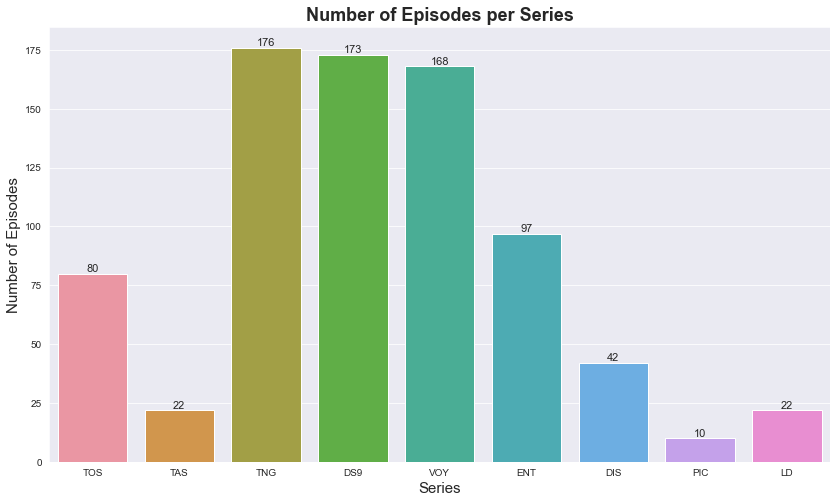

In [597]:
plt.figure(figsize=(14,8))
ax = sns.countplot(data=metadata_df, x = 'abbr',  
            order=['TOS', 'TAS', 'TNG', 'DS9', 'VOY', 'ENT', 'DIS', 'PIC', 'LD'])

ax.set_title('Number of Episodes per Series',fontsize = 18, fontweight='bold' )
ax.set_xlabel('Series', fontsize = 15)
ax.set_ylabel('Number of Episodes', fontsize = 15)

for rect in ax.patches:
    ax.text (rect.get_x() + rect.get_width()  / 2,rect.get_height()
             + 0.75,rect.get_height(),horizontalalignment='center', fontsize = 11)

plt.show()

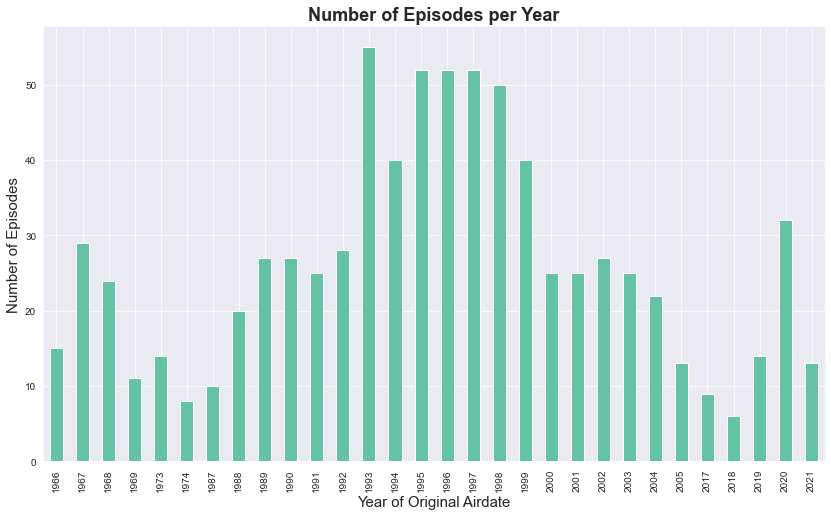

In [598]:
ax = metadata_df.groupby(metadata_df["original_airdate"].dt.year)['episode'].count().plot(kind="bar", \
                                                                                           figsize=(14,8))

ax.set_title('Number of Episodes per Year',fontsize = 18, fontweight='bold' )
ax.set_xlabel('Year of Original Airdate', fontsize = 15)
ax.set_ylabel('Number of Episodes', fontsize = 15)

plt.show()

### Clean Up Titles

In [599]:
metadata_df['title'].unique().tolist()

['The Cage',
 'Where No Man Has Gone Before',
 'The Corbomite Maneuver',
 "Mudd's Women",
 'The Enemy Within',
 'The Man Trap',
 'The Naked Time',
 'Charlie X',
 'Balance of Terror',
 'What Are Little Girls Made Of?',
 'Dagger of the Mind',
 'Miri',
 'The Conscience of the King',
 'The Galileo Seven',
 'Court Martial',
 'The Menagerie, Part I',
 'The Menagerie, Part II',
 'Shore Leave',
 'The Squire of Gothos',
 'Arena',
 'The Alternative Factor',
 'Tomorrow is Yesterday',
 'The Return of the Archons',
 'A Taste of Armageddon',
 'Space Seed',
 'This Side of Paradise',
 'The Devil in the Dark',
 'Errand of Mercy',
 'The City on the Edge of Forever',
 'Operation -- Annihilate!',
 'Catspaw',
 'Metamorphosis',
 "Friday's Child",
 'Who Mourns for Adonais?',
 'Amok Time',
 'The Doomsday Machine',
 'Wolf in the Fold',
 'The Changeling',
 'The Apple',
 'Mirror, Mirror',
 'The Deadly Years',
 'I, Mudd',
 'The Trouble with Tribbles',
 'Bread and Circuses',
 'Journey to Babel',
 'A Private Little

In [600]:
metadata_df['clean_title'] = metadata_df['title']

In [601]:
def strip_accents(text):
    try:
        text = unicode(text, 'utf-8')
    except NameError: # unicode is a default on python 3 
        pass

    text = unicodedata.normalize('NFD', text)\
           .encode('ascii', 'ignore')\
           .decode("utf-8")

    return str(text)

In [602]:
# Convert accent characters
#unidecode(somestring, "utf-8")
metadata_df['clean_title'] = metadata_df['clean_title'].map(lambda x: strip_accents(x))

In [603]:
# some episodes are appended with I and II
# This should be Part I and Part II
metadata_df.loc[metadata_df['title'] == 'Redemption', 'clean_title'] = 'Redemption Part I'
metadata_df.loc[metadata_df['title'] == 'Redemption II', 'clean_title'] = 'Redemption Part II'
metadata_df.loc[metadata_df['title'] == 'Unification I', 'clean_title'] = 'Unification Part I'
metadata_df.loc[metadata_df['title'] == 'Unification II', 'clean_title'] = 'Unification Part II'

In [604]:
metadata_df[(metadata_df['clean_title'].str.endswith(' II'))]

,episode,title,abbr,stardate,original_airdate,production_number,clean_title
16,1x16,"The Menagerie, Part II",TOS,3013.1 - 3013.2,1966-11-24,6149-16B,"The Menagerie, Part II"
175,4x01,"The Best of Both Worlds, Part II",TNG,44001.4,1990-09-24,40274-175,"The Best of Both Worlds, Part II"
201,5x01,Redemption II,TNG,45020.4,1991-09-23,40275-201,Redemption Part II
208,5x08,Unification II,TNG,45245.8,1991-11-11,40275-207,Unification Part II
227,6x01,"Time's Arrow, Part II",TNG,46001.3,1992-09-21,40276-227,"Time's Arrow, Part II"
237,6x11,"Chain of Command, Part II",TNG,46360.8,1992-12-21,40276-237,"Chain of Command, Part II"
243,6x17,"Birthright, Part II",TNG,46579.2,1993-03-01,40276-243,"Birthright, Part II"
253,7x01,"Descent, Part II",TNG,47025.4,1993-09-20,40277-253,"Descent, Part II"
257,7x05,"Gambit, Part II",TNG,47160.1,1993-10-18,40277-257,"Gambit, Part II"
317,2x21,"The Maquis, Part II",DS9,Unknown,1994-05-01,40512-441,"The Maquis, Part II"


In [605]:
def clean_parts(title):
    if title.endswith(' I'):
        clean_title = re.sub(' I$', ' 1', title)
        return clean_title
    elif title.endswith(' II'):
        clean_title = re.sub(' II$', ' 2', title)
        return clean_title
    else:
        return title

In [606]:
metadata_df['clean_title'] = metadata_df['clean_title'].map(lambda x: clean_parts(x))

In [607]:
metadata_df[(metadata_df['clean_title'].str.endswith(' 1'))]

,episode,title,abbr,stardate,original_airdate,production_number,clean_title
15,1x15,"The Menagerie, Part I",TOS,3012.4 - 3012.6,1966-11-17,6149-16A,"The Menagerie, Part 1"
200,4x26,Redemption,TNG,44995.3,1991-06-17,40274-200,Redemption Part 1
207,5x07,Unification I,TNG,45233.1,1991-11-04,40275-208,Unification Part 1
236,6x10,"Chain of Command, Part I",TNG,46357.4,1992-12-14,40276-236,"Chain of Command, Part 1"
242,6x16,"Birthright, Part I",TNG,46578.4,1993-02-22,40276-242,"Birthright, Part 1"
256,7x04,"Gambit, Part I",TNG,47135.2,1993-10-11,40277-256,"Gambit, Part 1"
316,2x20,"The Maquis, Part I",DS9,Unknown,1994-04-24,40512-440,"The Maquis, Part 1"
323,3x01,"The Search, Part I",DS9,48212.4-48214.5,1994-09-26,40512-447,"The Search, Part 1"
333,3x11,"Past Tense, Part I",DS9,48481.2,1995-01-08,40513-457,"Past Tense, Part 1"
491,2x26,"Basics, Part I",VOY,Unknown,1996-05-20,142,"Basics, Part 1"


In [608]:
# Superscript 'E²' -> 'E2'
metadata_df.loc[metadata_df['title'] == 'E²', 'clean_title'] = 'E2'

In [609]:
metadata_df.loc[metadata_df['title'].str.startswith('Vis')]
metadata_df.loc[metadata_df['title'] == 'Vis à Vis', 'clean_title'] = 'Vis a Vis'

In [610]:
def clean_title(title):
    clean_title = re.sub(r'[^a-zA-Z0-9 ]',r'', title)
    clean_title = clean_title.lower()
    clean_title = re.sub('\s+',' ', clean_title)
    
    return clean_title

In [611]:
metadata_df['clean_title'] = metadata_df['clean_title'].map(lambda x: clean_title(x))

### Manual Checks

In [612]:
metadata_df.loc[metadata_df['clean_title'] == 'descent', 'clean_title'] = 'descent part 1'

In [613]:
metadata_df.loc[metadata_df['clean_title'] == 'equinox', 'clean_title'] = 'equinox part 1'

In [614]:
metadata_df.loc[metadata_df['clean_title'] == 'futures end', 'clean_title'] = 'futures end part 1'

In [615]:
metadata_df.loc[metadata_df['clean_title'] == 'in a mirror darkly', 'clean_title'] = 'in a mirror darkly part 1'

In [616]:
metadata_df.loc[metadata_df['clean_title'] == 'shockwave', 'clean_title'] = 'shockwave part 1'

In [617]:
metadata_df.loc[metadata_df['clean_title'] == 'scorpion', 'clean_title'] = 'scorpion part 1'

In [618]:
metadata_df.loc[metadata_df['clean_title'] == 'storm front', 'clean_title'] = 'storm front part 1'

In [619]:
metadata_df.loc[metadata_df['clean_title'] == 'such sweet sorrow', 'clean_title'] = 'such sweet sorrow part 1'

In [620]:
metadata_df.loc[metadata_df['clean_title'] == 'the best of both worlds', 'clean_title'] = 'the best of both worlds part 1'

In [621]:
metadata_df.loc[metadata_df['clean_title'] == 'the killing game', 'clean_title'] = 'the killing game part 1'

In [622]:
metadata_df.loc[metadata_df['clean_title'] == 'times arrow', 'clean_title'] = 'times arrow part 1'

In [623]:
metadata_df.loc[metadata_df['clean_title'] == 'unimatrix zero', 'clean_title'] = 'unimatrix zero part 1'

In [624]:
metadata_df.loc[metadata_df['clean_title'] == 'unification iii', 'clean_title'] = 'unification part 3'

In [625]:
metadata_df.loc[metadata_df['clean_title'] == 'workforce', 'clean_title'] = 'workforce part 1'

In [626]:
metadata_df.loc[metadata_df['clean_title'] == 'year of hell', 'clean_title'] = 'year of hell part 1'

In [627]:
metadata_df.loc[metadata_df['clean_title'] == 'baddabing baddabang', 'clean_title'] = 'badda bing badda bang'

In [738]:
metadata_df.loc[metadata_df['clean_title'] == 'day of the dove', 'clean_title'] = 'the day of the dove'

In [783]:
metadata_df.loc[metadata_df['clean_title'] == 'hard time', 'clean_title'] = 'hard times'

In [830]:
metadata_df.loc[metadata_df['clean_title'] == 'sons of mogh', 'clean_title'] = 'the sons of mogh'

In [831]:
sorted(metadata_df['clean_title'].unique().tolist())

['11001001',
 '1159',
 'a fistful of datas',
 'a man alone',
 'a matter of honor',
 'a matter of perspective',
 'a matter of time',
 'a night in sickbay',
 'a piece of the action',
 'a private little war',
 'a simple investigation',
 'a taste of armageddon',
 'a time to stand',
 'absolute candor',
 'accession',
 'acquisition',
 'affliction',
 'afterimage',
 'albatross',
 'alice',
 'all good things',
 'all our yesterdays',
 'allegiance',
 'alliances',
 'alter ego',
 'amok time',
 'an obol for charon',
 'and the children shall lead',
 'angel one',
 'anomaly',
 'apocalypse rising',
 'aquiel',
 'arena',
 'armageddon game',
 'ashes to ashes',
 'assignment earth',
 'attached',
 'author author',
 'awakening',
 'azati prime',
 'babel',
 'babel one',
 'badda bing badda bang',
 'balance of terror',
 'bar association',
 'barge of the dead',
 'basics part 1',
 'basics part 2',
 'battle at the binary stars',
 'battle lines',
 'before and after',
 'behind the lines',
 'bem',
 'beyond the farthest st

In [832]:
metadata_df

,episode,title,abbr,stardate,original_airdate,production_number,clean_title
0,0x01,The Cage,TOS,Unknown,1988-10-04,6149-01,the cage
1,1x01,Where No Man Has Gone Before,TOS,1312.4 - 1313.8,1966-09-22,6149-02,where no man has gone before
2,1x02,The Corbomite Maneuver,TOS,1512.2 - 1514.1,1966-11-10,6149-03,the corbomite maneuver
3,1x03,Mudd's Women,TOS,1329.8 - 1330.1,1966-10-13,6149-04,mudds women
4,1x04,The Enemy Within,TOS,1672.1 - 1673.1,1966-10-06,6149-05,the enemy within
...,...,...,...,...,...,...,...
786,2x08,Episode 18,LD,Unknown,2021-09-30,208,episode 18
787,2x09,Episode 19,LD,Unknown,2021-10-07,209,episode 19
788,2x10,Episode 20,LD,Unknown,2021-10-14,210,episode 20
789,2x11,Episode 21,LD,Unknown,2021-10-21,211,episode 21


# Summaries

In [630]:
summaries_df.head()

,episode_abbr,episode_titles,episode_urls,summary_text_clean
0,TOS,The Cage,https://memory-alpha.fandom.com/wiki/The_Cage_...,"Captain Pike on the bridge The year is 2254, ..."
1,TOS,Where No Man Has Gone Before,https://memory-alpha.fandom.com/wiki/Where_No_...,"""I'll have you checkmated your next move…"" ""C..."
2,TOS,The Corbomite Maneuver,https://memory-alpha.fandom.com/wiki/The_Corbo...,The mysterious object The USS Enterprise is i...
3,TOS,Mudd's Women,https://memory-alpha.fandom.com/wiki/Mudd%27s_...,The USS Enterprise chases an unregistered sta...
4,TOS,The Enemy Within,https://memory-alpha.fandom.com/wiki/The_Enemy...,"During a survey of Alfa 177, geological techn..."


In [631]:
summaries_df.shape

(778, 4)

In [632]:
summaries_df.dtypes

episode_abbr          object
episode_titles        object
episode_urls          object
summary_text_clean    object
dtype: object

In [633]:
print("Number of series in Dataset: ", summaries_df['episode_abbr'].nunique())
print("Number of unique episode titles in Dataset: ", summaries_df['episode_titles'].nunique())
print("Number of unique episode scripts in Dataset: ", summaries_df['summary_text_clean'].nunique())

Number of series in Dataset:  9
Number of unique episode titles in Dataset:  778
Number of unique episode scripts in Dataset:  778


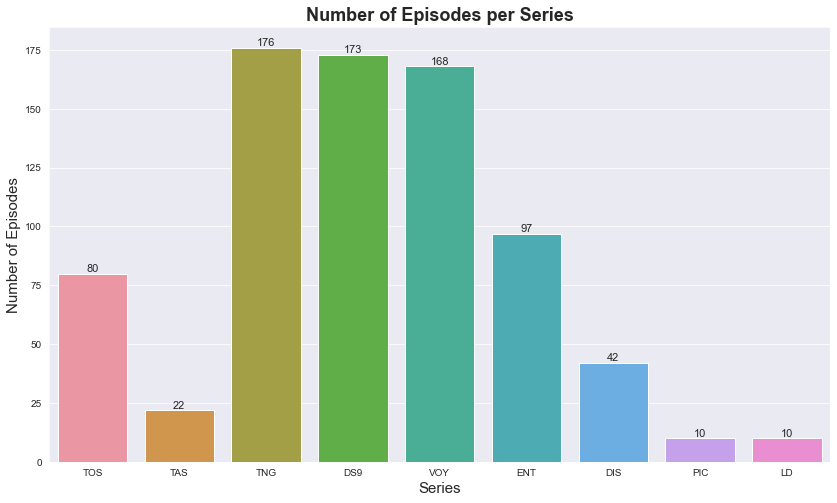

In [634]:
plt.figure(figsize=(14,8))
ax = sns.countplot(data=summaries_df, x = 'episode_abbr',  
            order=['TOS', 'TAS', 'TNG', 'DS9', 'VOY', 'ENT', 'DIS', 'PIC', 'LD'])

ax.set_title('Number of Episodes per Series',fontsize = 18, fontweight='bold' )
ax.set_xlabel('Series', fontsize = 15)
ax.set_ylabel('Number of Episodes', fontsize = 15)

for rect in ax.patches:
    ax.text (rect.get_x() + rect.get_width()  / 2,rect.get_height() 
             + 0.75,rect.get_height(),horizontalalignment='center', fontsize = 11)

plt.show()

In [635]:
summaries_df

,episode_abbr,episode_titles,episode_urls,summary_text_clean
0,TOS,The Cage,https://memory-alpha.fandom.com/wiki/The_Cage_...,"Captain Pike on the bridge The year is 2254, ..."
1,TOS,Where No Man Has Gone Before,https://memory-alpha.fandom.com/wiki/Where_No_...,"""I'll have you checkmated your next move…"" ""C..."
2,TOS,The Corbomite Maneuver,https://memory-alpha.fandom.com/wiki/The_Corbo...,The mysterious object The USS Enterprise is i...
3,TOS,Mudd's Women,https://memory-alpha.fandom.com/wiki/Mudd%27s_...,The USS Enterprise chases an unregistered sta...
4,TOS,The Enemy Within,https://memory-alpha.fandom.com/wiki/The_Enemy...,"During a survey of Alfa 177, geological techn..."
...,...,...,...,...
773,LD,Terminal Provocations,https://memory-alpha.fandom.com/wiki/Terminal_...,"In the lower decks crew quarters, Ensign Brad..."
774,LD,Much Ado About Boimler,https://memory-alpha.fandom.com/wiki/Much_Ado_...,"Ensigns Brad Boimler, Beckett Mariner, and Sa..."
775,LD,Veritas,https://memory-alpha.fandom.com/wiki/Veritas_(...,"On K'Tuevon Prime, Ensigns Beckett Mariner, B..."
776,LD,Crisis Point,https://memory-alpha.fandom.com/wiki/Crisis_Po...,"On the surface of a planet, a huge statue of ..."


In [833]:
# Check if titles in Summaries are also in Metadata
#metadata_df.where(metadata_df['title']==summaries_df['episode_titles']).notna()
summaries_full = pd.merge(metadata_df, summaries_df, left_on='title', right_on='episode_titles')

In [834]:
summaries_full.shape

(778, 11)

In [835]:
# Check for missing data
summaries_full.isna().sum()

episode               0
title                 0
abbr                  0
stardate              0
original_airdate      0
production_number     0
clean_title           0
episode_abbr          0
episode_titles        0
episode_urls          0
summary_text_clean    0
dtype: int64

In [836]:
summaries_full.head()

,episode,title,abbr,stardate,original_airdate,production_number,clean_title,episode_abbr,episode_titles,episode_urls,summary_text_clean
0,0x01,The Cage,TOS,Unknown,1988-10-04,6149-01,the cage,TOS,The Cage,https://memory-alpha.fandom.com/wiki/The_Cage_...,"Captain Pike on the bridge The year is 2254, ..."
1,1x01,Where No Man Has Gone Before,TOS,1312.4 - 1313.8,1966-09-22,6149-02,where no man has gone before,TOS,Where No Man Has Gone Before,https://memory-alpha.fandom.com/wiki/Where_No_...,"""I'll have you checkmated your next move…"" ""C..."
2,1x02,The Corbomite Maneuver,TOS,1512.2 - 1514.1,1966-11-10,6149-03,the corbomite maneuver,TOS,The Corbomite Maneuver,https://memory-alpha.fandom.com/wiki/The_Corbo...,The mysterious object The USS Enterprise is i...
3,1x03,Mudd's Women,TOS,1329.8 - 1330.1,1966-10-13,6149-04,mudds women,TOS,Mudd's Women,https://memory-alpha.fandom.com/wiki/Mudd%27s_...,The USS Enterprise chases an unregistered sta...
4,1x04,The Enemy Within,TOS,1672.1 - 1673.1,1966-10-06,6149-05,the enemy within,TOS,The Enemy Within,https://memory-alpha.fandom.com/wiki/The_Enemy...,"During a survey of Alfa 177, geological techn..."


In [837]:
# drop unnecessary columns
cols_to_drop = ['episode_abbr', 'episode_titles', 'episode_urls']

#st_metadata_df = 
summaries_full.drop(cols_to_drop, axis=1)

,episode,title,abbr,stardate,original_airdate,production_number,clean_title,summary_text_clean
0,0x01,The Cage,TOS,Unknown,1988-10-04,6149-01,the cage,"Captain Pike on the bridge The year is 2254, ..."
1,1x01,Where No Man Has Gone Before,TOS,1312.4 - 1313.8,1966-09-22,6149-02,where no man has gone before,"""I'll have you checkmated your next move…"" ""C..."
2,1x02,The Corbomite Maneuver,TOS,1512.2 - 1514.1,1966-11-10,6149-03,the corbomite maneuver,The mysterious object The USS Enterprise is i...
3,1x03,Mudd's Women,TOS,1329.8 - 1330.1,1966-10-13,6149-04,mudds women,The USS Enterprise chases an unregistered sta...
4,1x04,The Enemy Within,TOS,1672.1 - 1673.1,1966-10-06,6149-05,the enemy within,"During a survey of Alfa 177, geological techn..."
...,...,...,...,...,...,...,...,...
773,1x06,Terminal Provocations,LD,57663.9,2020-09-10,LD-1006,terminal provocations,"In the lower decks crew quarters, Ensign Brad..."
774,1x07,Much Ado About Boimler,LD,57752.6,2020-09-17,LD-1007,much ado about boimler,"Ensigns Brad Boimler, Beckett Mariner, and Sa..."
775,1x08,Veritas,LD,Unknown,2020-09-24,LD-1008,veritas,"On K'Tuevon Prime, Ensigns Beckett Mariner, B..."
776,1x09,Crisis Point,LD,Unknown,2020-10-01,LD-1009,crisis point,"On the surface of a planet, a huge statue of ..."


# Transcripts

In [641]:
transcripts_df.head()

,series,production_number,episode_title,script_link,transcript
0,StarTrek,1,The Cage,http://www.chakoteya.net/StarTrek/1.htm,\n\n\n\n\n\nThe Star Trek Transcripts - The Ca...
1,StarTrek,6,The Man Trap,http://www.chakoteya.net/StarTrek/6.htm,\n\n\n\n\n\nThe Star Trek Transcripts - The Ma...
2,StarTrek,8,Charlie X,http://www.chakoteya.net/StarTrek/8.htm,\n\n\n\n\n\nThe Star Trek Transcripts - Charli...
3,StarTrek,2,Where No Man Has Gone Before,http://www.chakoteya.net/StarTrek/2.htm,\n\n\n\n\n\nThe Star Trek Transcripts - Where ...
4,StarTrek,7,The Naked Time,http://www.chakoteya.net/StarTrek/7.htm,\n\n\n\n\n\nThe Star Trek Transcripts - The Na...


In [642]:
transcripts_df.shape

(727, 5)

In [643]:
print("Number of series in Dataset: ", transcripts_df['series'].nunique())
print("Number of unique episode titles in Dataset: ", transcripts_df['episode_title'].nunique())
print("Number of unique episode links in Dataset: ", transcripts_df['script_link'].nunique())
print("Number of unique episode scripts in Dataset: ", transcripts_df['transcript'].nunique())

Number of series in Dataset:  6
Number of unique episode titles in Dataset:  727
Number of unique episode links in Dataset:  727
Number of unique episode scripts in Dataset:  723


In [644]:
# Multi part episodes have the same transcripts
transcripts_df[transcripts_df['transcript'].duplicated(keep=False)]

,series,production_number,episode_title,script_link,transcript
491,Voyager,222,Basics Part I,http://www.chakoteya.net/Voyager/222.htm,\n\n\n\n\n\nThe Voyager Transcripts - Basics\n...
492,Voyager,222,Basics\r\nPart II,http://www.chakoteya.net/Voyager/222.htm#To%20...,\n\n\n\n\n\nThe Voyager Transcripts - Basics\n...
516,Voyager,321,Scorpion Part I,http://www.chakoteya.net/Voyager/321.htm,\n\n\n\n\n\nThe Voyager Transcripts - Scorpion...
517,Voyager,321,Scorpion\r\nPart 2,http://www.chakoteya.net/Voyager/321.htm#To%20...,\n\n\n\n\n\nThe Voyager Transcripts - Scorpion...
565,Voyager,525,Equinox Part I,http://www.chakoteya.net/Voyager/525.htm,\n\n\n\n\n\nThe Voyager Transcripts - Equinox\...
566,Voyager,525,Equinox\r\nPart 2,http://www.chakoteya.net/Voyager/525.htm#To%20...,\n\n\n\n\n\nThe Voyager Transcripts - Equinox\...
591,Voyager,625,Unimatrix Zero Part I,http://www.chakoteya.net/Voyager/625.htm,\n\n\n\n\n\nThe Voyager Transcripts - Unimatri...
592,Voyager,625,Unimatrix\r\nZero Part II,http://www.chakoteya.net/Voyager/625.htm#To%20...,\n\n\n\n\n\nThe Voyager Transcripts - Unimatri...


In [645]:
# split transcripts in multi part episodes
transcripts_df.iloc[491]['transcript'] = transcripts_df.iloc[491]['transcript'].split('To Be Continued...')[0]
transcripts_df.iloc[492]['transcript'] = transcripts_df.iloc[492]['transcript'].split('To Be Continued...')[1]

transcripts_df.iloc[516]['transcript'] = transcripts_df.iloc[516]['transcript'].split('To be continued')[0]
transcripts_df.iloc[517]['transcript'] = transcripts_df.iloc[517]['transcript'].split('To be continued')[1]

transcripts_df.iloc[565]['transcript'] = transcripts_df.iloc[565]['transcript'].split('To Be Continued...')[0]
transcripts_df.iloc[566]['transcript'] = transcripts_df.iloc[566]['transcript'].split('To Be Continued...')[1]

transcripts_df.iloc[591]['transcript'] = transcripts_df.iloc[591]['transcript'].split('To Be Continued...')[0]
transcripts_df.iloc[592]['transcript'] = transcripts_df.iloc[592]['transcript'].split('To Be Continued...')[1]

In [646]:
print("Number of unique episode scripts in Dataset: ", transcripts_df['transcript'].nunique())

Number of unique episode scripts in Dataset:  727


In [647]:
# Clean up multi part episode titles
transcripts_df.at[491, 'episode_title'] = 'Basics Part 1'
transcripts_df.at[492, 'episode_title'] = 'Basics Part 2'
transcripts_df.at[516, 'episode_title'] = 'Scorpion Part 1'
transcripts_df.at[517, 'episode_title'] = 'Scorpion Part 2'
transcripts_df.at[565, 'episode_title'] = 'Equinox Part 1'
transcripts_df.at[566, 'episode_title'] = 'Equinox Part 2'
transcripts_df.at[591, 'episode_title'] = 'Unimatrix Part 1'
transcripts_df.at[592, 'episode_title'] = 'Unimatrix Part 2'

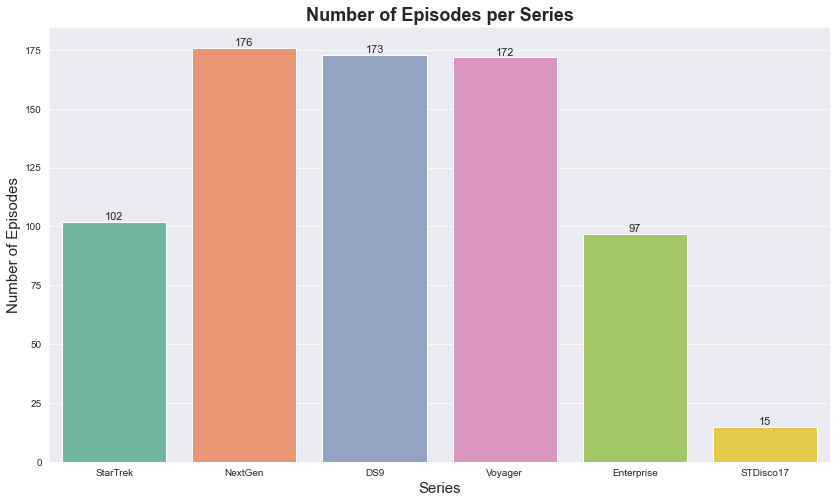

In [943]:
plt.figure(figsize=(14,8))
ax = sns.countplot(data=transcripts_df, x = 'series')

ax.set_title('Number of Episodes per Series',fontsize = 18, fontweight='bold' )
ax.set_xlabel('Series', fontsize = 15)
ax.set_ylabel('Number of Episodes', fontsize = 15)

for rect in ax.patches:
    ax.text (rect.get_x() + rect.get_width()  / 2,rect.get_height() 
             + 0.75,rect.get_height(),horizontalalignment='center', fontsize = 11)

plt.show()

--------------

In [838]:
# remove series from metadata where no transcripts exist
metadata_reduced = metadata_df[(metadata_df['abbr'] != 'PIC') & (metadata_df['abbr'] !='LD')]

In [839]:
# Transcripts only available for first season of Dicsovery
# Remove other seasons from deduced metadata
metadata_reduced = metadata_reduced.drop(metadata_reduced[(metadata_reduced['abbr'] == 'DIS') & \
                                      (metadata_reduced['production_number'] > '115')].index)

In [840]:
metadata_reduced

,episode,title,abbr,stardate,original_airdate,production_number,clean_title
0,0x01,The Cage,TOS,Unknown,1988-10-04,6149-01,the cage
1,1x01,Where No Man Has Gone Before,TOS,1312.4 - 1313.8,1966-09-22,6149-02,where no man has gone before
2,1x02,The Corbomite Maneuver,TOS,1512.2 - 1514.1,1966-11-10,6149-03,the corbomite maneuver
3,1x03,Mudd's Women,TOS,1329.8 - 1330.1,1966-10-13,6149-04,mudds women
4,1x04,The Enemy Within,TOS,1672.1 - 1673.1,1966-10-06,6149-05,the enemy within
...,...,...,...,...,...,...,...
727,1x11,The Wolf Inside,DIS,Unknown,2018-01-14,111,the wolf inside
728,1x12,Vaulting Ambition,DIS,Unknown,2018-01-21,112,vaulting ambition
729,1x13,What's Past Is Prologue,DIS,1834.2,2018-01-28,113,whats past is prologue
730,1x14,"The War Without, The War Within",DIS,Unknown,2018-02-04,114,the war without the war within


In [743]:
transcripts_df

,series,production_number,episode_title,script_link,transcript,clean_title
0,StarTrek,1,The Cage,http://www.chakoteya.net/StarTrek/1.htm,\n\n\n\n\n\nThe Star Trek Transcripts - The Ca...,the cage
1,StarTrek,6,The Man Trap,http://www.chakoteya.net/StarTrek/6.htm,\n\n\n\n\n\nThe Star Trek Transcripts - The Ma...,the man trap
2,StarTrek,8,Charlie X,http://www.chakoteya.net/StarTrek/8.htm,\n\n\n\n\n\nThe Star Trek Transcripts - Charli...,charlie x
3,StarTrek,2,Where No Man Has Gone Before,http://www.chakoteya.net/StarTrek/2.htm,\n\n\n\n\n\nThe Star Trek Transcripts - Where ...,where no man has gone before
4,StarTrek,7,The Naked Time,http://www.chakoteya.net/StarTrek/7.htm,\n\n\n\n\n\nThe Star Trek Transcripts - The Na...,the naked time
...,...,...,...,...,...,...
722,STDisco17,111,The Wolf Inside,http://www.chakoteya.net/STDisco17/111.html,\n\n\n\n\n\nStar Trek Discovery Transcripts - ...,the wolf inside
723,STDisco17,112,Vaulting Ambition,http://www.chakoteya.net/STDisco17/112.html,\n\n\n\n\n\nStar Trek Discovery Transcripts - ...,vaulting ambition
724,STDisco17,113,What's Past is Prologue,http://www.chakoteya.net/STDisco17/113.html,\n\n\n\n\n\nStar Trek Discovery Transcripts - ...,whats past is prologue
725,STDisco17,114,"The War Without, The War Within",http://www.chakoteya.net/STDisco17/114.html,\n\n\n\n\n\nStar Trek Discovery Transcripts - ...,the war without the war within


In [744]:
transcripts_df['clean_title'] = transcripts_df['episode_title'].map(lambda x: strip_accents(x))

In [745]:
def clean_title(title):
    # remove leading/trailing whitespace
    clean_title = title.strip()
    # replace '\r\n' char sequance
    clean_title = clean_title.replace('\r\n',' ')
    # remove special characters
    clean_title = re.sub(r'[^a-zA-Z0-9 ]',r'', clean_title)
    # to lowercase
    clean_title = clean_title.lower()
    
    # remove accents
    
    return clean_title

In [746]:
transcripts_df['clean_title'] = transcripts_df['clean_title'].map(lambda x: clean_title(x))

In [747]:
transcripts_df

,series,production_number,episode_title,script_link,transcript,clean_title
0,StarTrek,1,The Cage,http://www.chakoteya.net/StarTrek/1.htm,\n\n\n\n\n\nThe Star Trek Transcripts - The Ca...,the cage
1,StarTrek,6,The Man Trap,http://www.chakoteya.net/StarTrek/6.htm,\n\n\n\n\n\nThe Star Trek Transcripts - The Ma...,the man trap
2,StarTrek,8,Charlie X,http://www.chakoteya.net/StarTrek/8.htm,\n\n\n\n\n\nThe Star Trek Transcripts - Charli...,charlie x
3,StarTrek,2,Where No Man Has Gone Before,http://www.chakoteya.net/StarTrek/2.htm,\n\n\n\n\n\nThe Star Trek Transcripts - Where ...,where no man has gone before
4,StarTrek,7,The Naked Time,http://www.chakoteya.net/StarTrek/7.htm,\n\n\n\n\n\nThe Star Trek Transcripts - The Na...,the naked time
...,...,...,...,...,...,...
722,STDisco17,111,The Wolf Inside,http://www.chakoteya.net/STDisco17/111.html,\n\n\n\n\n\nStar Trek Discovery Transcripts - ...,the wolf inside
723,STDisco17,112,Vaulting Ambition,http://www.chakoteya.net/STDisco17/112.html,\n\n\n\n\n\nStar Trek Discovery Transcripts - ...,vaulting ambition
724,STDisco17,113,What's Past is Prologue,http://www.chakoteya.net/STDisco17/113.html,\n\n\n\n\n\nStar Trek Discovery Transcripts - ...,whats past is prologue
725,STDisco17,114,"The War Without, The War Within",http://www.chakoteya.net/STDisco17/114.html,\n\n\n\n\n\nStar Trek Discovery Transcripts - ...,the war without the war within


In [748]:
def clean_parts(title):
    if title.endswith(' part one'):
        clean_title = re.sub(' one$', ' 1', title)
        return clean_title
    elif title.endswith(' part two'):
        clean_title = re.sub(' two$', ' 2', title)
        return clean_title
    else:
        return title

In [749]:
transcripts_df['clean_title'] = transcripts_df['clean_title'].map(lambda x: clean_parts(x))

### Manual Checks

In [750]:
transcripts_df.loc[transcripts_df['clean_title'] == 'a matter of honour', 'clean_title'] = 'a matter of honor'
transcripts_df.loc[transcripts_df['clean_title'] == 'best of both worlds part 1', 'clean_title'] = 'the best of both worlds part 1'
transcripts_df.loc[transcripts_df['clean_title'] == 'best of both worlds part 2', 'clean_title'] = 'the best of both worlds part 2'
transcripts_df.loc[transcripts_df['clean_title'] == 'code of honour', 'clean_title'] = 'code of honor'

In [751]:
transcripts_df.loc[transcripts_df['clean_title'] == 'favour the bold', 'clean_title'] = 'favor the bold'

In [764]:
transcripts_df.loc[transcripts_df['clean_title'] == 'for the world is hollow', 'clean_title'] = 'for the world is hollow and i have touched the sky'

In [775]:
transcripts_df.loc[transcripts_df['clean_title'] == 'hide  q', 'clean_title'] = 'hide and q'

In [797]:
transcripts_df.loc[transcripts_df['clean_title'] == 'in a mirror darkly pt 1', 'clean_title'] = 'in a mirror darkly part 1'

In [798]:
transcripts_df.loc[transcripts_df['clean_title'] == 'in a mirror darkly pt 2', 'clean_title'] = 'in a mirror darkly part 2'

In [810]:
transcripts_df.loc[transcripts_df['clean_title'] == 'honour among thieves', 'clean_title'] = 'honor among thieves'

In [816]:
transcripts_df.loc[transcripts_df['clean_title'] == 'looking for parmach', 'clean_title'] = 'looking for parmach in all the wrong places'

In [820]:
transcripts_df.loc[transcripts_df['clean_title'] == 'till death do us part', 'clean_title'] = 'til death do us part'

In [821]:
transcripts_df.loc[transcripts_df['clean_title'] == 'two day and two nights', 'clean_title'] = 'two days and two nights'

In [846]:
transcripts_df.loc[transcripts_df['clean_title'] == 'unimatrix part 1', 'clean_title'] = 'unimatrix zero part 1'

In [847]:
transcripts_df.loc[transcripts_df['clean_title'] == 'unimatrix part 2', 'clean_title'] = 'unimatrix zero part 2'

In [894]:
transcripts_df.loc[transcripts_df['clean_title'] == 'redemption', 'clean_title'] = 'redemption part 1'

In [928]:
transcripts_df.loc[transcripts_df['clean_title'] == 'futures end', 'clean_title'] = 'futures end part 1'

In [929]:
transcripts_df.loc[transcripts_df['clean_title'] == 'the killing game', 'clean_title'] = 'the killing game part 1'

In [930]:
transcripts_df.loc[transcripts_df['clean_title'] == 'workforce', 'clean_title'] = 'workforce part 1'

In [931]:
transcripts_df.loc[transcripts_df['clean_title'] == 'year of hell', 'clean_title'] = 'year of hell part 1'

In [939]:
transcript_titles_list = transcripts_df['clean_title'].unique().tolist()
metadata_titles_list = metadata_reduced['clean_title'].unique().tolist()

In [940]:
title_diffs = sorted(list(set(metadata_titles_list) ^ set(transcript_titles_list)))

In [941]:
title_diffs

['the killing game part 2', 'workforce part 2']

In [942]:
sorted(transcripts_df['clean_title'].unique().tolist())

['11001001',
 '1159',
 'a fistful of datas',
 'a man alone',
 'a matter of honor',
 'a matter of perspective',
 'a matter of time',
 'a night in sickbay',
 'a piece of the action',
 'a private little war',
 'a simple investigation',
 'a taste of armageddon',
 'a time to stand',
 'accession',
 'acquisition',
 'affliction',
 'afterimage',
 'albatross',
 'alice',
 'all good things',
 'all our yesterdays',
 'allegiance',
 'alliances',
 'alter ego',
 'amok time',
 'and the children shall lead',
 'angel one',
 'anomaly',
 'apocalypse rising',
 'aquiel',
 'arena',
 'armageddon game',
 'ashes to ashes',
 'assignment earth',
 'attached',
 'author author',
 'awakening',
 'azati prime',
 'babel',
 'babel one',
 'badda bing badda bang',
 'balance of terror',
 'bar association',
 'barge of the dead',
 'basics part 1',
 'basics part 2',
 'battle at the binary stars',
 'battle lines',
 'before and after',
 'behind the lines',
 'bem',
 'beyond the farthest star',
 'birthright part 1',
 'birthright par

In [920]:
len(title_diffs)

8

In [445]:
len(title_diffs)

78

### Merge Metadata and Transcripts

In [921]:
# Check if titles in Summaries are also in Metadata
#metadata_df.where(metadata_df['title']==summaries_df['episode_titles']).notna()
transcripts_full = pd.merge(metadata_reduced, transcripts_df, left_on='clean_title',\
                          right_on='clean_title', how='outer')

In [922]:
transcripts_full.head()

,episode,title,abbr,stardate,original_airdate,production_number_x,clean_title,series,production_number_y,episode_title,script_link,transcript
0,0x01,The Cage,TOS,Unknown,1988-10-04,6149-01,the cage,StarTrek,1,The Cage,http://www.chakoteya.net/StarTrek/1.htm,\n\n\n\n\n\nThe Star Trek Transcripts - The Ca...
1,1x01,Where No Man Has Gone Before,TOS,1312.4 - 1313.8,1966-09-22,6149-02,where no man has gone before,StarTrek,2,Where No Man Has Gone Before,http://www.chakoteya.net/StarTrek/2.htm,\n\n\n\n\n\nThe Star Trek Transcripts - Where ...
2,1x02,The Corbomite Maneuver,TOS,1512.2 - 1514.1,1966-11-10,6149-03,the corbomite maneuver,StarTrek,3,The Corbomite Maneuver,http://www.chakoteya.net/StarTrek/3.htm,\n\n\n\n\n\nThe Star Trek Transcripts - The Co...
3,1x03,Mudd's Women,TOS,1329.8 - 1330.1,1966-10-13,6149-04,mudds women,StarTrek,4,Mudd's Women,http://www.chakoteya.net/StarTrek/4.htm,\n\n\n\n\n\nThe Star Trek Transcripts - Mudd's...
4,1x04,The Enemy Within,TOS,1672.1 - 1673.1,1966-10-06,6149-05,the enemy within,StarTrek,5,The Enemy Within,http://www.chakoteya.net/StarTrek/5.htm,\n\n\n\n\n\nThe Star Trek Transcripts - The En...


In [923]:
transcripts_full.shape

(735, 12)

In [924]:
# Check for missing data
transcripts_full.isna().sum()

episode                4
title                  4
abbr                   4
stardate               4
original_airdate       4
production_number_x    4
clean_title            0
series                 4
production_number_y    4
episode_title          4
script_link            4
transcript             4
dtype: int64

<AxesSubplot:>

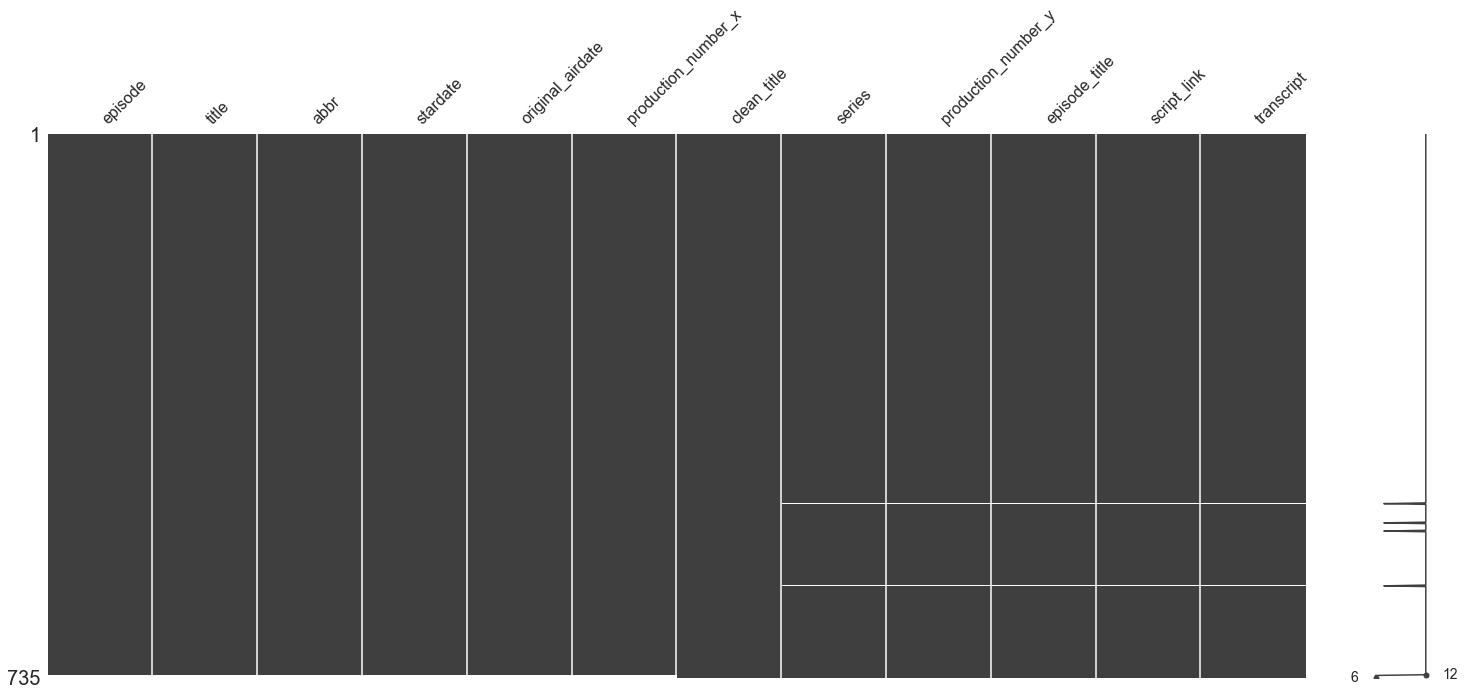

In [925]:
# Check structure of missing data
msno.matrix(transcripts_full)

In [926]:
# Which episodes don't have transcripts?
transcripts_full[transcripts_full['title'].isna()]

,episode,title,abbr,stardate,original_airdate,production_number_x,clean_title,series,production_number_y,episode_title,script_link,transcript
731,NaN,NaN,NaN,NaN,NaT,NaN,futures end,Voyager,304,Future's End,http://www.chakoteya.net/Voyager/304.htm,\n\n\n\n\n\nThe Voyager Transcripts - Future's...
732,NaN,NaN,NaN,NaN,NaT,NaN,year of hell,Voyager,407,Year of Hell,http://www.chakoteya.net/Voyager/407.htm,\n\n\n\n\n\nThe Voyager Transcripts - Year of ...
733,NaN,NaN,NaN,NaN,NaT,NaN,the killing game,Voyager,416,The Killing Game,http://www.chakoteya.net/Voyager/416.htm,\n\n\n\n\n\nThe Voyager Transcripts - The Kill...
734,NaN,NaN,NaN,NaN,NaT,NaN,workforce,Voyager,714,Workforce,http://www.chakoteya.net/Voyager/714.htm,\n\n\n\n\n\n\nThe Voyager Transcripts - Workfo...


In [906]:
multipart_list = transcripts_full.loc[transcripts_full['title'].isna()]['clean_title'].tolist()

In [907]:
multipart_df = transcripts_df[transcripts_df['clean_title'].isin(multipart_list)].reset_index(drop=True)

In [910]:
multipart_df

,series,production_number,episode_title,script_link,transcript,clean_title
0,Voyager,304,Future's End,http://www.chakoteya.net/Voyager/304.htm,\n [Kerbside\r\n- Metro Plaza] \n (Paris\r\nis...,futures end
1,Voyager,407,Year of Hell,http://www.chakoteya.net/Voyager/407.htm,"\n\n Day\r\n133 \n\r\nCaptain's log, stardate ...",year of hell
2,Voyager,416,The Killing Game,http://www.chakoteya.net/Voyager/416.htm,\n\n [Sainte Claire - Street]CHAKOTAY: Move ou...,the killing game
3,Voyager,714,Workforce,http://www.chakoteya.net/Voyager/714.htm,\n\n[Gantry](Chakotay picks up a metal rod and...,workforce


In [909]:
# split transcripts in multi part episodes
multipart_df.iloc[0]['transcript'] = multipart_df.iloc[0]['transcript'].split('To be continued...')[1]
multipart_df.iloc[1]['transcript'] = multipart_df.iloc[1]['transcript'].split('To Be Continued...')[1]
multipart_df.iloc[2]['transcript'] = multipart_df.iloc[2]['transcript'].split('To Be Continued...')[1]
multipart_df.iloc[3]['transcript'] = multipart_df.iloc[3]['transcript'].split('To Be Continued...')[1]

In [936]:
multipart_df.loc[multipart_df['clean_title'] == 'futures end', 'clean_title'] = 'futures end part 2'
multipart_df.loc[multipart_df['clean_title'] == 'year of hell', 'clean_title'] = 'year of hell part 2'
multipart_df.loc[multipart_df['clean_title'] == 'the killing game', 'clean_title'] = 'the killing game part 2'
multipart_df.loc[multipart_df['clean_title'] == 'workforce', 'clean_title'] = 'workforce part 2'

In [937]:
transcripts_df = pd.concat([transcripts_df, multipart_df])

In [938]:
print("Number of unique episode scripts in Dataset: ", transcripts_df['transcript'].nunique())

Number of unique episode scripts in Dataset:  731


In [867]:
sorted(metadata_reduced['clean_title'].unique().tolist())

['11001001',
 '1159',
 'a fistful of datas',
 'a man alone',
 'a matter of honor',
 'a matter of perspective',
 'a matter of time',
 'a night in sickbay',
 'a piece of the action',
 'a private little war',
 'a simple investigation',
 'a taste of armageddon',
 'a time to stand',
 'accession',
 'acquisition',
 'affliction',
 'afterimage',
 'albatross',
 'alice',
 'all good things',
 'all our yesterdays',
 'allegiance',
 'alliances',
 'alter ego',
 'amok time',
 'and the children shall lead',
 'angel one',
 'anomaly',
 'apocalypse rising',
 'aquiel',
 'arena',
 'armageddon game',
 'ashes to ashes',
 'assignment earth',
 'attached',
 'author author',
 'awakening',
 'azati prime',
 'babel',
 'babel one',
 'badda bing badda bang',
 'balance of terror',
 'bar association',
 'barge of the dead',
 'basics part 1',
 'basics part 2',
 'battle at the binary stars',
 'battle lines',
 'before and after',
 'behind the lines',
 'bem',
 'beyond the farthest star',
 'birthright part 1',
 'birthright par

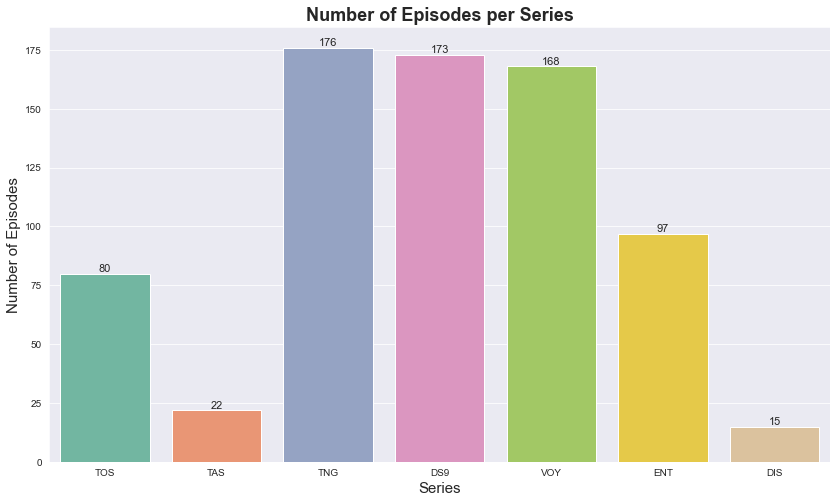

In [944]:
plt.figure(figsize=(14,8))
ax = sns.countplot(data=transcripts_full, x = 'abbr')

ax.set_title('Number of Episodes per Series',fontsize = 18, fontweight='bold' )
ax.set_xlabel('Series', fontsize = 15)
ax.set_ylabel('Number of Episodes', fontsize = 15)

for rect in ax.patches:
    ax.text (rect.get_x() + rect.get_width()  / 2,rect.get_height() 
             + 0.75,rect.get_height(),horizontalalignment='center', fontsize = 11)

plt.show()

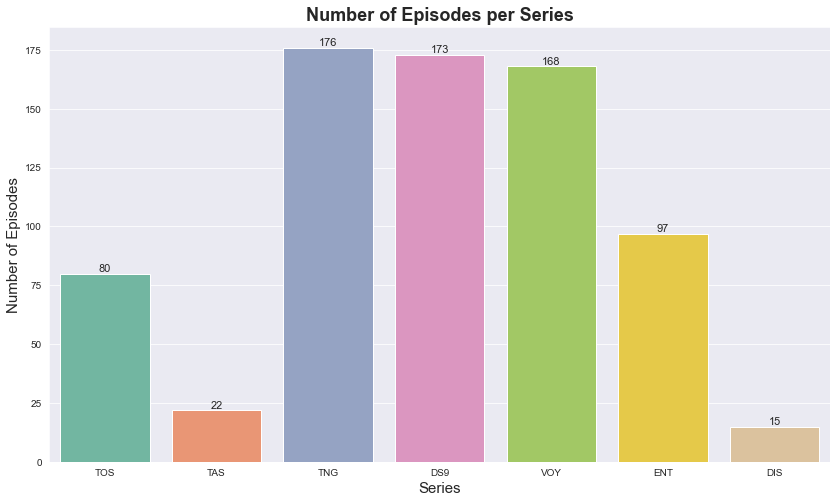

In [947]:
plt.figure(figsize=(14,8))
ax = sns.countplot(data=metadata_reduced, x = 'abbr')

ax.set_title('Number of Episodes per Series',fontsize = 18, fontweight='bold' )
ax.set_xlabel('Series', fontsize = 15)
ax.set_ylabel('Number of Episodes', fontsize = 15)

for rect in ax.patches:
    ax.text (rect.get_x() + rect.get_width()  / 2,rect.get_height() 
             + 0.75,rect.get_height(),horizontalalignment='center', fontsize = 11)

plt.show()

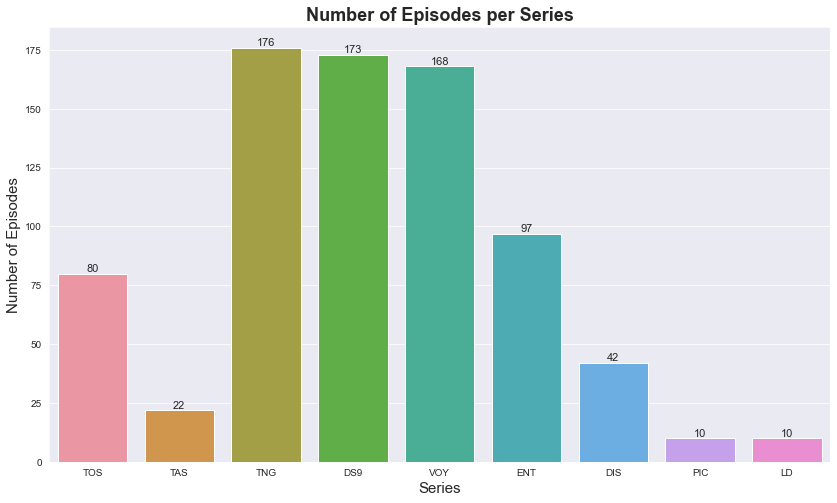

In [948]:
plt.figure(figsize=(14,8))
ax = sns.countplot(data=summaries_full, x = 'abbr')

ax.set_title('Number of Episodes per Series',fontsize = 18, fontweight='bold' )
ax.set_xlabel('Series', fontsize = 15)
ax.set_ylabel('Number of Episodes', fontsize = 15)

for rect in ax.patches:
    ax.text (rect.get_x() + rect.get_width()  / 2,rect.get_height() 
             + 0.75,rect.get_height(),horizontalalignment='center', fontsize = 11)

plt.show()

In [ ]:
# Titles have different formatting in datasets
# in transcripts there are character combinations '\r\n',
# spaces around titles.
# Multiple part episodes: 'part 1' should become 'Part I'
# 'Operation: Annihilate!' vs 'Operation -- Annihilate!'
# replace 'part 1' with 'Part I'
    #clean_title = clean_title.replace('part 1', 'Part I')
    # replace 'part 2' with 'Part II'
    #clean_title = clean_title.replace('part 2', 'Part II')
    # 'E2' -> 'E²'
    # 'In A Mirror, Darkly pt 1', 'In A Mirror, Darkly pt 2'
    # 'In a Mirror, Darkly', 'In a Mirror, Darkly, Part II'
    # 'Unimatrix Zero Part I', 'Unimatrix Zero Part II'
    # 'Unimatrix Zero', 'Unimatrix Zero, Part II'
    # 'Workforce' - 'Workforce', 'Workforce, Part II'
    # 'Equinox Part I', 'Equinox Part 2'
    # 'Equinox', 'Equinox, Part II'

In [ ]:
# Two part episodes have the same transcripts
episodes_df[episodes_df.duplicated(['transcript'])]

In [103]:
# Create mapping from series names to abbreviations
series_names_chakoteya = transcripts_df['series'].unique().tolist()
print(series_names_chakoteya)
series_abbrs = metadata_df['abbr'].unique().tolist()
# There are no Transcripts for 'Picard' and 'Lower Decks'
# remove abbreviations from list
print(series_abbrs)

# Zip two lists into dictionary for mapping

# 'StarTrek' contains both TOS and TAS
# difference is in production numbers

# For each row:
    # Check if 'series' is 'StarTrek':
        # Check for production_numbers that contain 'TAS'
    # Map other values from abbreviation map



['StarTrek', 'NextGen', 'DS9', 'Voyager', 'Enterprise', 'STDisco17']
['TOS', 'TAS', 'TNG', 'DS9', 'VOY', 'ENT', 'DIS', 'PIC', 'LD']
